#POLICY DATA - ETL

#Import Libraries and Data

###Imports

In [230]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math
!pip install plotly
import plotly.express as px
!pip install squarify
import squarify
import matplotlib.colors as mcolors
import numpy as np

### Connecting to Drive

Below cells are for data connection

In [78]:
# delete the legacy files from the workbook
!rm /content/sample_data/*.*

In [79]:
# attach the local google drive - select your UPenn google account
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
# validate that you have access to the group project raw data archive folder
!ls -al "/content/drive/Shareddrives/CIS 5450 Group Project/Data/Raw Archive"

total 1130718
-rw------- 1 root root     414039 Apr  4 16:21 'Census of Employment 2019-2023.csv'
-rw------- 1 root root    6766441 Apr 10 11:29  GL_Exposure_Details.csv
-rw------- 1 root root 1150661659 Apr  9 02:17  Policy_Data.csv
-rw------- 1 root root        176 Mar 29 13:41  ReadMe.gdoc
-rw------- 1 root root      11084 Apr  4 13:45  test.csv


In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
# copy the policy data from the raw data drive into colab (~20 seconds)
#!cd /content/sample_data/
source = "/content/drive/Shareddrives/CIS 5450 Group Project/Data/Raw Archive/Policy_Data.csv"
destination = "/content/sample_data/"
!cp "$source" "$destination"

#ETL - Basic Exploring and Transforming of Data


##Exploring the basics of the data (shape, nof rows, dtype)

In [83]:
# create initial data frame for policy data (takes ~30 seconds)
policy_data_df = pd.read_csv("./sample_data/Policy_Data.csv", encoding="utf-8", dtype={'column_8': str, 'column_40': str},  low_memory=False)
print("Initial Policy Load Column Count: {}".format(policy_data_df.shape[1]))

Initial Policy Load Column Count: 51


In [84]:
#preview
policy_data_df.head()

,DivisionName,RegionName,BranchName,DataSourceCode,ProductMasterLineTypeName,ProductMasterCoverageTypeName,ProductMasterLineName,ProductLineName,ClientID,ClientMasterCityName,...,EffectiveDate,BilledPremium,DCF_Revenue,Key,Limits,Exposure,Pay_Roll,GROSS_SALES,EMPLOYEE_COUNT,LOCATION_REVENUE
0,Risk Placement Services,RPS Binding,RPS Western-Binding,DV_Production - 1,Commercial,Casualty,C - General Liability,Commercial General Liability,86940,Henderson,...,2013-03-03 00:00:00.0000000,1210.0,121.00,60129542144,NaN,NaN,NaN,NaN,NaN,NaN
1,Risk Placement Services,RPS Binding,RPS Western-Binding,DV_Production - 1,Commercial,Worker's Compensation,C - Workers Compensation-All Other,Workers Compensation,76248021,Keene,...,2023-07-02 00:00:00.0000000,1239.0,61.95,60129542145,NaN,NaN,NaN,NaN,NaN,NaN
2,Risk Placement Services,RPS Binding,RPS Western-Binding,DV_Production - 1,Commercial,Casualty,C - General Liability,Commercial General Liability,9535489,NaN,...,2012-08-31 00:00:00.0000000,1485.0,321.07,60129542146,NaN,NaN,NaN,NaN,NaN,NaN
3,Risk Placement Services,RPS Binding,RPS Western-Binding,DV_Production - 1,Commercial,Casualty,C - General Liability,Commercial General Liability,71344524,Boulder,...,2023-08-01 00:00:00.0000000,9695.0,794.75,60129542147,NaN,NaN,NaN,NaN,NaN,NaN
4,Risk Placement Services,RPS Binding,RPS Western-Binding,DV_Production - 1,Commercial,Casualty,C - General Liability,Commercial General Liability,75982339,NaN,...,2017-09-08 00:00:00.0000000,1761.0,332.08,60129542148,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
#data types
print(policy_data_df.dtypes)

DivisionName                                object
RegionName                                  object
BranchName                                  object
DataSourceCode                              object
ProductMasterLineTypeName                   object
ProductMasterCoverageTypeName               object
ProductMasterLineName                       object
ProductLineName                             object
ClientID                                    object
ClientMasterCityName                        object
ClientMasterStateName                       object
CityName                                    object
StateCode                                   object
StateName                                   object
SICPrimaryKey                                int64
NAICSPrimary1Key                             int64
CompanySalesAmt_USD                        float64
ThreeYear_GrowthPct_SalesAmt               float64
EmployeesTotalCount                        float64
ThreeYear_GrowthPct_EmployeeCou

In [86]:
#no. of rows and columns
policy_data_df.shape

(1893601, 51)

In [87]:
# Check non_null_counts before dropping NULLS
policy_data_non_null_counts = policy_data_df.notnull().sum()
print(policy_data_non_null_counts)

DivisionName                               1893601
RegionName                                 1893601
BranchName                                 1893601
DataSourceCode                             1893601
ProductMasterLineTypeName                  1893601
ProductMasterCoverageTypeName              1893601
ProductMasterLineName                      1893601
ProductLineName                            1893601
ClientID                                   1893601
ClientMasterCityName                       1086013
ClientMasterStateName                      1085971
CityName                                   1747855
StateCode                                  1660201
StateName                                  1748719
SICPrimaryKey                              1893601
NAICSPrimary1Key                           1893601
CompanySalesAmt_USD                        1086047
ThreeYear_GrowthPct_SalesAmt               1086020
EmployeesTotalCount                        1086052
ThreeYear_GrowthPct_EmployeeCou

In [88]:
# create the clean policy dataframe for cleaning and eventual output (saves on reloading policy_df during testing)
clean_policy_data_df = policy_data_df.copy()

In [89]:
clean_policy_data_df.shape

(1893601, 51)

## Drop not needed (or repetitive data) columns

In [90]:
# Drop not neededcolumns
drop_columns = ["DivisionName", "RegionName", "BranchName", "DataSourceCode", "ProductMasterLineTypeName", "ClientMasterStateName",
                "ClientMasterCityName", "TransactionTypeKey", "Pay_Roll", "GROSS_SALES", "EMPLOYEE_COUNT", "LOCATION_REVENUE",
                "CityName", "NAICSPrimary1Key", "SICPrimaryKey", "ThreeYear_GrowthPct_SalesAmt", "ThreeYear_GrowthPct_EmployeeCount"]
clean_policy_data_df.drop(columns = drop_columns, inplace=True)
print("Post Drop Column Count: {}".format(clean_policy_data_df.shape[1]))

Post Drop Column Count: 34


In [91]:
#no. of rows and columns
clean_policy_data_df.shape

(1893601, 34)

##Filtering Dates

**Filter out policy Effective Dates not between 2013 and 2022 inclusive and creating a new dimension, `Year`**




In [92]:
#Count how many rows are in the DataFrame clean_policy_data_df
start_row_count = clean_policy_data_df.shape[0]

# Add 'Year' column based on policy 'EffectiveDate'
clean_policy_data_df['Year'] = pd.to_datetime(clean_policy_data_df['EffectiveDate']).dt.year

# Drop rows with missing values in 'Year' directly from original DataFrame
clean_policy_data_df.dropna(subset=['Year'], inplace=True)

# Convert 'Year' to integer type
clean_policy_data_df['Year'] = clean_policy_data_df['Year'].astype(int)

# Filter rows based on year range using .loc to modify the original DataFrame
clean_policy_data_df = clean_policy_data_df.loc[(clean_policy_data_df['Year'] >= 2013) & (clean_policy_data_df['Year'] <= 2022)]

# Calculate rows removed
rows_removed = start_row_count - clean_policy_data_df.shape[0]
print("Effective Date Cleanse Rows Removed:", rows_removed)

Effective Date Cleanse Rows Removed: 312425


##Cleaning State Field

In [93]:
# Populate state code if state name is valid but code is not
state_dict = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

nan_state_count = clean_policy_data_df['StateCode'].isna().sum()
# Replace NaN state codes with the corresponding state code using the dictionary
clean_policy_data_df['StateCode'] = clean_policy_data_df['StateCode'].fillna(clean_policy_data_df['StateName'].map(state_dict))
print("State Codes Corrected: ", nan_state_count - clean_policy_data_df['StateCode'].isna().sum())

State Codes Corrected:  64369


In [94]:
start_row_count = clean_policy_data_df.shape[0]
state_list = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

# Convert list to DataFrame
#valid_states = pd.DataFrame(state_list, columns=["StateCode"])
clean_policy_data_df = clean_policy_data_df[clean_policy_data_df["StateCode"].isin(state_list)]

# Calculate rows removed
rows_removed = start_row_count - clean_policy_data_df.shape[0]
print("State Cleanse Rows Removed:", rows_removed)

State Cleanse Rows Removed: 140173


In [95]:
# drop state name column (duplicate info)
clean_policy_data_df.drop(columns = "StateName", inplace=True)

In [96]:
non_null_counts = clean_policy_data_df.notnull().sum()
print(non_null_counts)

ProductMasterCoverageTypeName              1441003
ProductMasterLineName                      1441003
ProductLineName                            1441003
ClientID                                   1441003
StateCode                                  1441003
CompanySalesAmt_USD                         897500
EmployeesTotalCount                         897502
SIC_4_Code                                 1441003
IndustryCode                               1441003
SIC_3_Code                                 1441003
IndustryGroupDesc                          1441003
SIC_2_Code                                 1441003
IndustryMajorGroupDesc                     1441003
NAICSLevel2Code                            1435387
NAICSLevel3Code                            1435387
NAICSLevel4Code                            1435387
NAICSLevel5Code                            1435387
IndustryGroupCode                          1435387
IndustryCategoryCode                       1435387
IndustryTypeCode               

In [97]:
#Null counts
null_counts = clean_policy_data_df.isnull().sum()
print(null_counts)

ProductMasterCoverageTypeName                    0
ProductMasterLineName                            0
ProductLineName                                  0
ClientID                                         0
StateCode                                        0
CompanySalesAmt_USD                         543503
EmployeesTotalCount                         543501
SIC_4_Code                                       0
IndustryCode                                     0
SIC_3_Code                                       0
IndustryGroupDesc                                0
SIC_2_Code                                       0
IndustryMajorGroupDesc                           0
NAICSLevel2Code                               5616
NAICSLevel3Code                               5616
NAICSLevel4Code                               5616
NAICSLevel5Code                               5616
IndustryGroupCode                             5616
IndustryCategoryCode                          5616
IndustryTypeCode               

##Drop null rows

In [98]:
# delete nulls in "CityName", "NAICSLevel5Code", "CarrierMasterParentName", "CarrierParentPayeeMarketTypeName", "TierName","CarrierParentIntermediaryMarketTypeName"
clean_policy_data_df = clean_policy_data_df.dropna(subset=["NAICSLevel5Code", "CarrierMasterParentName", "CarrierParentPayeeMarketTypeName", "TierName","CarrierParentIntermediaryMarketTypeName"])

In [99]:
#Null counts -
null_counts = clean_policy_data_df.isnull().sum()
print(null_counts)

ProductMasterCoverageTypeName                    0
ProductMasterLineName                            0
ProductLineName                                  0
ClientID                                         0
StateCode                                        0
CompanySalesAmt_USD                         543201
EmployeesTotalCount                         543199
SIC_4_Code                                       0
IndustryCode                                     0
SIC_3_Code                                       0
IndustryGroupDesc                                0
SIC_2_Code                                       0
IndustryMajorGroupDesc                           0
NAICSLevel2Code                                  0
NAICSLevel3Code                                  0
NAICSLevel4Code                                  0
NAICSLevel5Code                                  0
IndustryGroupCode                                0
IndustryCategoryCode                             0
IndustryTypeCode               

In [100]:
# Check non_null_counts after dropping NULLS
non_null_counts = clean_policy_data_df.notnull().sum()
print(non_null_counts)

ProductMasterCoverageTypeName              1434159
ProductMasterLineName                      1434159
ProductLineName                            1434159
ClientID                                   1434159
StateCode                                  1434159
CompanySalesAmt_USD                         890958
EmployeesTotalCount                         890960
SIC_4_Code                                 1434159
IndustryCode                               1434159
SIC_3_Code                                 1434159
IndustryGroupDesc                          1434159
SIC_2_Code                                 1434159
IndustryMajorGroupDesc                     1434159
NAICSLevel2Code                            1434159
NAICSLevel3Code                            1434159
NAICSLevel4Code                            1434159
NAICSLevel5Code                            1434159
IndustryGroupCode                          1434159
IndustryCategoryCode                       1434159
IndustryTypeCode               

##Filter out CarrierMasterParentName

**Filter out `CarrierMasterParentName` rows that has less than 100 occurances**

If a `CarrierMasterParentName`hass less than 100 policies in the past 10 years, it's not interest for this analysis.

In [101]:
# First, let's count the occurrences of each unique 'CarrierMasterParentName'
carrier_parent_counts = clean_policy_data_df['CarrierMasterParentName'].value_counts()

# Now, keep the rows with occurrences >= 100
clean_policy_data_df = clean_policy_data_df[clean_policy_data_df['CarrierMasterParentName'].isin(carrier_parent_counts[carrier_parent_counts >= 100].index)]


In [102]:
non_null_counts = clean_policy_data_df.notnull().sum()
print(non_null_counts)

ProductMasterCoverageTypeName              1420631
ProductMasterLineName                      1420631
ProductLineName                            1420631
ClientID                                   1420631
StateCode                                  1420631
CompanySalesAmt_USD                         879632
EmployeesTotalCount                         879634
SIC_4_Code                                 1420631
IndustryCode                               1420631
SIC_3_Code                                 1420631
IndustryGroupDesc                          1420631
SIC_2_Code                                 1420631
IndustryMajorGroupDesc                     1420631
NAICSLevel2Code                            1420631
NAICSLevel3Code                            1420631
NAICSLevel4Code                            1420631
NAICSLevel5Code                            1420631
IndustryGroupCode                          1420631
IndustryCategoryCode                       1420631
IndustryTypeCode               

In [103]:
clean_policy_data_df.shape

(1420631, 34)

#ETL - Profiling the Dimensions

Review unique values for each column.

In [104]:
print(clean_policy_data_df.dtypes)

ProductMasterCoverageTypeName               object
ProductMasterLineName                       object
ProductLineName                             object
ClientID                                    object
StateCode                                   object
CompanySalesAmt_USD                        float64
EmployeesTotalCount                        float64
SIC_4_Code                                  object
IndustryCode                                object
SIC_3_Code                                  object
IndustryGroupDesc                           object
SIC_2_Code                                  object
IndustryMajorGroupDesc                      object
NAICSLevel2Code                             object
NAICSLevel3Code                             object
NAICSLevel4Code                             object
NAICSLevel5Code                             object
IndustryGroupCode                           object
IndustryCategoryCode                        object
IndustryTypeCode               

### Exploring Possible Data Quality Issues in Categorical Data

In [105]:
def profile_the_cat_policy_data(clean_policy_data_df):
  #ProductMasterCoverageTypeName
  print("number of unique values in:\n")
  print("'ProductMasterCoverageTypeName': {}".format(len(set(clean_policy_data_df['ProductMasterCoverageTypeName'].unique()))))

  #ProductMasterLineName
  print("'ProductMasterLineName': {}".format(len(set(clean_policy_data_df['ProductMasterLineName'].unique()))))

  #ProductLineName
  print("'ProductLineName': {}".format(len(set(clean_policy_data_df['ProductLineName'].unique()))))

  #ClientID
  print("'ClientID': {}".format(len(set(clean_policy_data_df['ClientID'].unique()))))

  #StateCode
  print("'StateCode': {}".format(len(set(clean_policy_data_df['StateCode'].unique()))))

  #SIC_4_Code and IndustryCode
  print("'SIC_4_Code' and 'IndustryCode': {}, {}".format(len(clean_policy_data_df['SIC_4_Code'].unique()), len(clean_policy_data_df['IndustryCode'].unique())))

  #SIC_3_Code and IndustryGroupDesc
  print("'SIC_3_Code' and 'IndustryGroupDesc': {}, {}".format(len(clean_policy_data_df['SIC_3_Code'].unique()), len(clean_policy_data_df['IndustryGroupDesc'].unique())))

  #SIC_2_Code and IndustryMajorGroupDesc
  print("'SIC_2_Code' and 'IndustryGroupCode': {}, {}".format(len(clean_policy_data_df['SIC_2_Code'].unique()), len(clean_policy_data_df['IndustryMajorGroupDesc'].unique())))

  # NAICSLevel2Code and IndustryClassCode
  print("'NAICSLevel2Code' and 'IndustryClassCode': {}, {}".format(len(clean_policy_data_df['NAICSLevel2Code'].unique()), len(clean_policy_data_df['IndustryClassCode'].unique())))

  # NAICSLevel3Code and IndustryTypeCode
  print("'NAICSLevel3Code' and 'IndustryTypeCode': {}, {}".format(len(clean_policy_data_df['NAICSLevel3Code'].unique()), len(clean_policy_data_df['IndustryTypeCode'].unique())))

  # NAICSLevel4Code and IndustryCategoryCode
  print("'NAICSLevel4Code' and 'IndustryCategoryCode': {}, {}".format(len(clean_policy_data_df['NAICSLevel4Code'].unique()), len(clean_policy_data_df['IndustryCategoryCode'].unique())))

  # NAICSLevel5Code and IndustryGroupCode
  print("'NAICSLevel5Code' and 'IndustryGroupCode': {}, {}".format(len(clean_policy_data_df['NAICSLevel5Code'].unique()), len(clean_policy_data_df['IndustryGroupCode'].unique())))

  #TransactionTypeDescription
  print("'TransactionTypeDescription': {}".format(len(set(clean_policy_data_df['TransactionTypeDescription'].unique()))))

  #CarrierMasterParentName
  print("'CarrierMasterParentName': {}".format(len(set(clean_policy_data_df['CarrierMasterParentName'].unique()))))

  #CarrierParentPayeeMarketTypeName
  print("'CarrierParentPayeeMarketTypeName': {}".format(len(set(clean_policy_data_df['CarrierParentPayeeMarketTypeName'].unique()))))

  #CarrierParentIntermediaryMarketTypeName
  print("'CarrierParentIntermediaryMarketTypeName': {}".format(len(set(clean_policy_data_df['CarrierParentIntermediaryMarketTypeName'].unique()))))

  #TierName
  print("'TierName': {}".format(len(set(clean_policy_data_df['TierName'].unique()))))

  #PolicyID
  print("'PolicyID': {}".format(len(set(clean_policy_data_df['PolicyID'].unique()))))

  #Year
  print("'Year': {}".format(len(set(clean_policy_data_df['Year'].unique()))))

In [106]:
profile_the_cat_policy_data(clean_policy_data_df)

number of unique values in:

'ProductMasterCoverageTypeName': 2
'ProductMasterLineName': 4
'ProductLineName': 45
'ClientID': 345219
'StateCode': 50
'SIC_4_Code' and 'IndustryCode': 961, 959
'SIC_3_Code' and 'IndustryGroupDesc': 410, 411
'SIC_2_Code' and 'IndustryGroupCode': 83, 83
'NAICSLevel2Code' and 'IndustryClassCode': 27, 23
'NAICSLevel3Code' and 'IndustryTypeCode': 99, 99
'NAICSLevel4Code' and 'IndustryCategoryCode': 312, 312
'NAICSLevel5Code' and 'IndustryGroupCode': 698, 696
'TransactionTypeDescription': 2
'CarrierMasterParentName': 250
'CarrierParentPayeeMarketTypeName': 4
'CarrierParentIntermediaryMarketTypeName': 4
'TierName': 6
'PolicyID': 972242
'Year': 10


#### Exploring mismatch between '`SIC_4_Code`' and '`IndustryCode`'
No. of unique values (IndustryCode) < No. of unique values (SIC_4_Code)

959 < 961

Expected 1 to 1 match.

**Conclusion after research and consulting with a subject matter expert:**

Mismatches are normal since the same descriptions exist for different SIC_4_Code numbers.  

Research Links:

https://www.osha.gov/sic-manual/5043

https://www.osha.gov/sic-manual/3861

https://www.osha.gov/sic-manual/3851

https://www.osha.gov/sic-manual/5048

In [107]:
SIC_4_Code_df = clean_policy_data_df[['SIC_4_Code', 'IndustryCode']].drop_duplicates()
SIC_4_Code_df_test = SIC_4_Code_df.groupby('IndustryCode')['IndustryCode'].count()
SIC_4_Code_df_test= SIC_4_Code_df_test.to_frame().rename(columns={'IndustryCode':'count'}).reset_index()
SIC_4_Code_df_test = SIC_4_Code_df_test.sort_values(by='count', ascending = False)
SIC_4_Code_df_test

,IndustryCode,count
663,Photographic equipment and supplies,2
625,Ophthalmic goods,2
0,Abrasive products,1
644,Paperboard mills,1
633,Packaged frozen goods,1
...,...,...
324,"Food preparations, nec",1
325,Food products machinery,1
326,Footwear,1
327,Footwear cut stock,1


In [108]:
SIC_4_Code_df_problem_rows = SIC_4_Code_df[(SIC_4_Code_df['IndustryCode'] == "Photographic equipment and supplies") | (SIC_4_Code_df['IndustryCode'] == "Ophthalmic goods")]
SIC_4_Code_df_problem_rows

,SIC_4_Code,IndustryCode
41222,3861,Photographic equipment and supplies
82500,5048,Ophthalmic goods
167464,3851,Ophthalmic goods
1161786,5043,Photographic equipment and supplies


In [109]:
SIC_4_Code_row_count_df = clean_policy_data_df[(clean_policy_data_df['IndustryCode'] == "Photographic equipment and supplies") | (clean_policy_data_df['IndustryCode'] == "Ophthalmic goods")]
SIC_4_Code_row_count_df = SIC_4_Code_row_count_df.groupby('SIC_4_Code')['SIC_4_Code'].count()
SIC_4_Code_row_count_df = SIC_4_Code_row_count_df.to_frame().rename(columns={'SIC_4_Code':'count'}).reset_index()
SIC_4_Code_row_count_df = SIC_4_Code_row_count_df.sort_values(by='count', ascending = False)
SIC_4_Code_row_count_df

,SIC_4_Code,count
1,3861,164
0,3851,51
3,5048,41
2,5043,35


In [110]:
SIC_4_Code_fullRow = clean_policy_data_df[(clean_policy_data_df['IndustryCode'] == "Ophthalmic goods")]
SIC_4_Code_fullRow = SIC_4_Code_fullRow[['SIC_4_Code' , 'SIC_3_Code', 'SIC_2_Code']]
# SIC_4_Code_fullRow

#### Exploring mismatch between `SIC_3_Code` and `IndustryGroupDesc`

No. of unique values (IndustryGroupDesc) > No. of unique values (SIC_3_Code)

411 < 410

Expected 1 to 1 match


**Conclusion after exploration:**

Mismatch is the result of case issue.

**Note:** The case difference issue has been fixed by capitalizing each string dimension of the data.

In [111]:
SIC_3_Code_df = clean_policy_data_df[['SIC_3_Code', 'IndustryGroupDesc']].drop_duplicates()
SIC_3_Code_df_test = SIC_3_Code_df.groupby('SIC_3_Code')['SIC_3_Code'].count()
SIC_3_Code_df_test= SIC_3_Code_df_test.to_frame().rename(columns={'SIC_3_Code':'count'}).reset_index()
SIC_3_Code_df_test = SIC_3_Code_df_test.sort_values(by='count', ascending = False)
SIC_3_Code_df_test

,SIC_3_Code,count
40,153,2
0,011,1
270,561,1
280,581,1
279,573,1
...,...,...
135,324,1
134,323,1
133,322,1
132,321,1


In [112]:
SIC_3_Code_df_problem_rows = SIC_3_Code_df[(SIC_3_Code_df['SIC_3_Code'] == "153")]
SIC_3_Code_df_problem_rows

,SIC_3_Code,IndustryGroupDesc
19610,153,Operative Builders
1191222,153,Operative builders


##### Capitalizing each String field

In [113]:
# Capitalizing string fields to solve the issue for SIC_3_Code_df
def to_upper(col):
    if col.dtype == "object":
        return col.str.upper()
    else:
        return col

clean_policy_data_df = clean_policy_data_df.apply(to_upper)
clean_policy_data_df.head(5)

,ProductMasterCoverageTypeName,ProductMasterLineName,ProductLineName,ClientID,StateCode,CompanySalesAmt_USD,EmployeesTotalCount,SIC_4_Code,IndustryCode,SIC_3_Code,...,CarrierParentIntermediaryMarketTypeName,TierName,PolicyID,EffectiveDate,BilledPremium,DCF_Revenue,Key,Limits,Exposure,Year
0,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,86940,NV,99289.0,1.0,8711,ENGINEERING SERVICES,871,...,NOT APPLICABLE,TIER 2,0135881,2013-03-03 00:00:00.0000000,1210.0,121.00,60129542144,NaN,NaN,2013
4,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,75982339,TX,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,...,NOT APPLICABLE,TIER 3,CED805318,2017-09-08 00:00:00.0000000,1761.0,332.08,60129542148,NaN,NaN,2017
6,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,75798163,TX,220486.0,6.0,1521,SINGLE-FAMILY HOUSING CONSTRUCTION,152,...,NOT APPLICABLE,TIER 2,CED852139,2020-05-22 00:00:00.0000000,944.0,249.96,60129542150,NaN,NaN,2020
7,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,57224179,WA,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,...,NOT APPLICABLE,TIER 3,4374194,2021-09-27 00:00:00.0000000,800.0,230.00,60129542151,NaN,NaN,2021
8,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,75796524,TX,114296.0,6.0,9999,NONCLASSIFIABLE ESTABLISHMENTS,999,...,NOT APPLICABLE,TIER 3,CED847614,2020-02-22 00:00:00.0000000,1869.0,186.90,60129542152,NaN,NaN,2020


In [114]:
SIC_3_Code_afterFix = clean_policy_data_df[(clean_policy_data_df["SIC_3_Code"] == "153")]
SIC_3_Code_afterFix = SIC_3_Code_afterFix[["SIC_3_Code","IndustryGroupDesc"]]
SIC_3_Code_afterFix

,SIC_3_Code,IndustryGroupDesc
19610,153,OPERATIVE BUILDERS
19670,153,OPERATIVE BUILDERS
19730,153,OPERATIVE BUILDERS
19790,153,OPERATIVE BUILDERS
38406,153,OPERATIVE BUILDERS
...,...,...
1872688,153,OPERATIVE BUILDERS
1887815,153,OPERATIVE BUILDERS
1889732,153,OPERATIVE BUILDERS
1889792,153,OPERATIVE BUILDERS


#### Exploring mismatch between '`NAICSLevel2Code`' and '`IndustryClassCode`'

No. of unique values (NAICSLevel2Code) > No. of unique values (IndustryClassCode)

27 > 23

Expected 1 to 1 match


**Conclusion after research and consulting with a subject matter expert:**

This is correct, since 31-33 is "Manufacturing" and 48-49	"Transportation and Warehousing", 44-45	"Retail Trade"

https://www.census.gov/programs-surveys/economic-census/year/2022/guidance/understanding-naics.html

In [115]:
NAICSLevel2Code_df = clean_policy_data_df[['NAICSLevel2Code', 'IndustryClassCode']].drop_duplicates()
NAICSLevel2Code_df_test = NAICSLevel2Code_df.groupby('IndustryClassCode')['IndustryClassCode'].count()
NAICSLevel2Code_df_test= NAICSLevel2Code_df_test.to_frame().rename(columns={'IndustryClassCode':'count'}).reset_index()
NAICSLevel2Code_df_test = NAICSLevel2Code_df_test.sort_values(by='count', ascending = False)
NAICSLevel2Code_df_test

,IndustryClassCode,count
10,MANUFACTURING,3
18,TRANSPORTATION AND WAREHOUSING,2
17,RETAIL TRADE,2
0,ACCOMMODATION AND FOOD SERVICES,1
12,NO MATCH,1
21,UTILITIES,1
20,UNKNOWN,1
19,UNCLASSIFIED ESTABLISHMENTS,1
16,REAL ESTATE AND RENTAL AND LEASING,1
15,PUBLIC ADMINISTRATION,1


#### Exploring mismatch between '`NAICSLevel5Code`' and '`IndustryGroupCode`'
No. of unique values (NAICSLevel5Code) > No. of unique values (IndustryGroupCode)

698 > 696

Expected 1 to 1 match.

**Conclusion after research and consulting with a subject matter expert:**

Mismatches are normal since classification has been updated over the years as can be searched in the database.

https://www.census.gov/naics/?input=21113&year=2017&details=21113  



In [116]:
NAICSLevel5Code_df = clean_policy_data_df[['NAICSLevel5Code', 'IndustryGroupCode']].drop_duplicates()
NAICSLevel5Code_df_test = NAICSLevel5Code_df.groupby('IndustryGroupCode')['IndustryGroupCode'].count()
NAICSLevel5Code_df_test= NAICSLevel5Code_df_test.to_frame().rename(columns={'IndustryGroupCode':'count'}).reset_index()
NAICSLevel5Code_df_test = NAICSLevel5Code_df_test.sort_values(by='count', ascending = False)
NAICSLevel5Code_df_test

,IndustryGroupCode,count
397,OIL AND GAS EXTRACTION,3
0,ABRASIVE PRODUCT MANUFACTURING,1
468,OTHER SUPPORT ACTIVITIES FOR TRANSPORTATION,1
460,OTHER SERVICES RELATED TO ADVERTISING,1
461,OTHER SERVICES TO BUILDINGS AND DWELLINGS,1
...,...,...
233,GRAIN AND FIELD BEAN MERCHANT WHOLESALERS,1
234,GRANTMAKING AND GIVING SERVICES,1
235,GRAPHIC DESIGN SERVICES,1
236,GYPSUM PRODUCT MANUFACTURING,1


#### Review After Asddressing Data Quality Issues in Categorical Data

In [117]:
profile_the_cat_policy_data(clean_policy_data_df)

number of unique values in:

'ProductMasterCoverageTypeName': 2
'ProductMasterLineName': 4
'ProductLineName': 45
'ClientID': 345219
'StateCode': 50
'SIC_4_Code' and 'IndustryCode': 961, 959
'SIC_3_Code' and 'IndustryGroupDesc': 410, 410
'SIC_2_Code' and 'IndustryGroupCode': 83, 83
'NAICSLevel2Code' and 'IndustryClassCode': 27, 23
'NAICSLevel3Code' and 'IndustryTypeCode': 99, 99
'NAICSLevel4Code' and 'IndustryCategoryCode': 312, 312
'NAICSLevel5Code' and 'IndustryGroupCode': 698, 696
'TransactionTypeDescription': 2
'CarrierMasterParentName': 250
'CarrierParentPayeeMarketTypeName': 4
'CarrierParentIntermediaryMarketTypeName': 4
'TierName': 6
'PolicyID': 972242
'Year': 10


In [118]:
clean_policy_data_df.shape

(1420631, 34)

In [119]:
non_null_counts = clean_policy_data_df.notnull().sum()
print(non_null_counts)

ProductMasterCoverageTypeName              1420631
ProductMasterLineName                      1420631
ProductLineName                            1420631
ClientID                                   1420631
StateCode                                  1420631
CompanySalesAmt_USD                         879632
EmployeesTotalCount                         879634
SIC_4_Code                                 1420631
IndustryCode                               1420631
SIC_3_Code                                 1420631
IndustryGroupDesc                          1420631
SIC_2_Code                                 1420631
IndustryMajorGroupDesc                     1420631
NAICSLevel2Code                            1420631
NAICSLevel3Code                            1420631
NAICSLevel4Code                            1420631
NAICSLevel5Code                            1420631
IndustryGroupCode                          1420631
IndustryCategoryCode                       1420631
IndustryTypeCode               

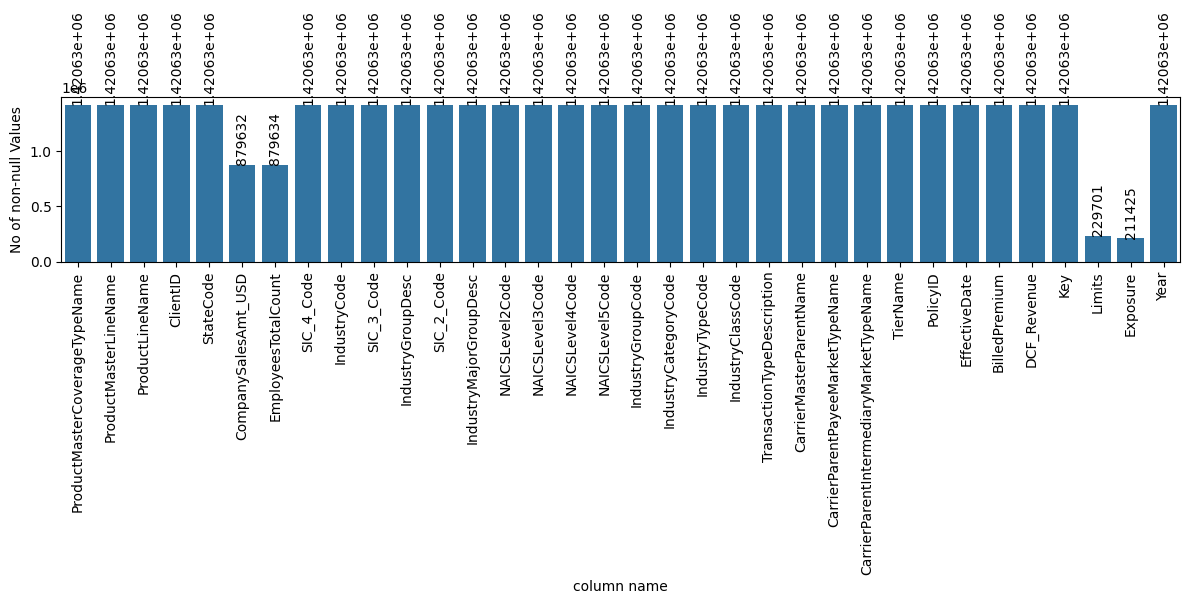

In [120]:
#data - number of recorsd
# no of non-null values for each column
column_counts = clean_policy_data_df.notnull().sum()

column_counts_df = column_counts.reset_index()
column_counts_df.columns = ['Column', 'Count']

plt.figure(figsize=(12, 6))
x = sns.barplot(x='Column', y='Count', data=column_counts_df)
plt.xlabel('column name')
plt.ylabel('No of non-null Values')
plt.xticks(rotation=90)

for container in x.containers:
    x.bar_label(container, label_type='edge',rotation=90)

plt.tight_layout()
plt.show()

### Creation of "HasAudit" field | Creation of `all_policy_data_df`

In [121]:
# # copy the cleaned DataFrame to a new variable for further processing
clean_all_data_df = clean_policy_data_df

#filter the DataFrame to include only rows where the TransactionTypeDescription is "AUDIT TRANSACTION"
clean_all_audit_df = clean_all_data_df[clean_all_data_df["TransactionTypeDescription"]=="AUDIT TRANSACTION"]
clean_all_audit_df

#filter the DataFrame to include only rows where the TransactionTypeDescription is "POLICY AMOUNT"
clean_all_policy_df = clean_all_data_df[clean_all_data_df["TransactionTypeDescription"]=="POLICY AMOUNT"]

#select specific columns from the audit transactions DataFrame and create a new DataFrame
merge_all_audit_df = clean_all_audit_df[["PolicyID", "EffectiveDate", "BilledPremium", "DCF_Revenue", "Key"]]

#rename the columns of the new audit DataFrame to reflect that they are from audit transactions
merge_all_audit_df.columns = ["PolicyID", "AuditEffectiveDate", "AuditBilledPremium", "AuditDCF_Revenue", "AuditKey"]

#merge the policy transactions DataFrame with the modified audit transactions DataFrame on the PolicyID column
#use a left join to keep all rows from the policy DataFrame and only matching rows from the audit DataFrame
all_policy_data_df = pd.merge(clean_all_policy_df, merge_all_audit_df, on="PolicyID", how="left")

# creating a new column 'HasAudit' to indicate whether an audit record exists (1) or not (0) for each policy
all_policy_data_df["HasAudit"] = np.where(all_policy_data_df["AuditKey"].isnull(), 0, 1)

# create combined audit records for both GL and WC
clean_all_data_df = clean_policy_data_df
clean_all_audit_df = clean_all_data_df[clean_all_data_df["TransactionTypeDescription"]=="AUDIT TRANSACTION"]
clean_all_policy_df = clean_all_data_df[clean_all_data_df["TransactionTypeDescription"]=="POLICY AMOUNT"]
merge_all_audit_df = clean_all_audit_df[["PolicyID","EffectiveDate","BilledPremium","DCF_Revenue","Key"]]
merge_all_audit_df.columns = ["PolicyID", "AuditEffectiveDate", "AuditBilledPremium", "AuditDCF_Revenue", "AuditKey"]
all_policy_data_df = pd.merge(clean_all_policy_df, merge_all_audit_df, on="PolicyID", how="left")

# "HasAudit" is a calculated binary field showing if a client is audited (1) or not (0)
all_policy_data_df["HasAudit"] = np.where(all_policy_data_df["AuditKey"].isnull(), 0, 1)

In [122]:
# all_policy_data_df.head()

#### Drop not needed (or repetitive data) columns after merge

In [123]:
# Drop not neededcolumns
drop_columns = ["AuditEffectiveDate", "AuditBilledPremium", "AuditDCF_Revenue", "AuditKey"]
all_policy_data_df.drop(columns = drop_columns, inplace=True)
print("Post Drop Column Count: {}".format(all_policy_data_df.shape[1]))

Post Drop Column Count: 35


In [124]:
all_policy_data_df.shape

(1272514, 35)

In [125]:
# non_null_counts = all_policy_data_df.notnull().sum()
# print(non_null_counts)

In [126]:
profile_the_cat_policy_data(all_policy_data_df)

number of unique values in:

'ProductMasterCoverageTypeName': 2
'ProductMasterLineName': 4
'ProductLineName': 45
'ClientID': 343060
'StateCode': 50
'SIC_4_Code' and 'IndustryCode': 961, 959
'SIC_3_Code' and 'IndustryGroupDesc': 410, 410
'SIC_2_Code' and 'IndustryGroupCode': 83, 83
'NAICSLevel2Code' and 'IndustryClassCode': 27, 23
'NAICSLevel3Code' and 'IndustryTypeCode': 99, 99
'NAICSLevel4Code' and 'IndustryCategoryCode': 312, 312
'NAICSLevel5Code' and 'IndustryGroupCode': 698, 696
'TransactionTypeDescription': 1
'CarrierMasterParentName': 250
'CarrierParentPayeeMarketTypeName': 4
'CarrierParentIntermediaryMarketTypeName': 4
'TierName': 6
'PolicyID': 963226
'Year': 10


### Exploring Possible Data Quality Issues in Numeric Data

Evaluated Fields
CompanySalesAmt_USD, EmployeesTotalCount,

In [127]:
# print(all_policy_data_df.dtypes)

In [128]:
# print the range of numeric values for each numeric column
def print_numeric_ranges(df):
  numeric_df = df.select_dtypes(include=['number'])

  for column in numeric_df.columns:
      min = numeric_df[column].min()
      max = numeric_df[column].max()
      print(f"range for {column}: {min} to {max}")

In [129]:
print_numeric_ranges(all_policy_data_df)

range for CompanySalesAmt_USD: 0.0 to 611289000000.0
range for EmployeesTotalCount: 0.0 to 2100000.0
range for BilledPremium: -2418896.0 to 24196897.0
range for DCF_Revenue: -346000.0 to 1027681.46
range for Key: 0 to 60129774019
range for Limits: 0.0 to 1526025000.0
range for Exposure: 0.0 to 52000000000.0
range for Year: 2013 to 2022
range for HasAudit: 0 to 1


####Exploring Negative Values in `BilledPremium`

In [130]:
BilledPremium_df = all_policy_data_df[['BilledPremium']]
print(f"Total number of BilledPremium rows", BilledPremium_df.shape[0])

BilledPremium_neg_df = BilledPremium_df[BilledPremium_df["BilledPremium"] < 0]
print(f"Total number of (-) BilledPremium rows", BilledPremium_neg_df.shape[0], "~", round(BilledPremium_neg_df.shape[0]/BilledPremium_df.shape[0]*100,0), "% of rows has negative BilledPremium values")

BilledPremium_0_df = BilledPremium_df[BilledPremium_df["BilledPremium"] == 0]
print(f"Total number of 0 BilledPremium rows", BilledPremium_0_df.shape[0], "~", round(BilledPremium_0_df.shape[0]/BilledPremium_df.shape[0]*100,0), "% of rows has zero BilledPremium values")


BilledPremium_pos_df = BilledPremium_df[BilledPremium_df["BilledPremium"] > 0]
print(f"Total number of (+) BilledPremium rows", BilledPremium_pos_df.shape[0], "~", round(BilledPremium_pos_df.shape[0]/BilledPremium_df.shape[0]*100,0), "% of rows has positive BilledPremium values")


Total number of BilledPremium rows 1272514
Total number of (-) BilledPremium rows 141973 ~ 11.0 % of rows has negative BilledPremium values
Total number of 0 BilledPremium rows 30803 ~ 2.0 % of rows has zero BilledPremium values
Total number of (+) BilledPremium rows 1099738 ~ 86.0 % of rows has positive BilledPremium values


In [131]:
temp_df = all_policy_data_df[all_policy_data_df["CarrierMasterParentName"]=="TRAVELERS GROUP"]
temp_df

,ProductMasterCoverageTypeName,ProductMasterLineName,ProductLineName,ClientID,StateCode,CompanySalesAmt_USD,EmployeesTotalCount,SIC_4_Code,IndustryCode,SIC_3_Code,...,TierName,PolicyID,EffectiveDate,BilledPremium,DCF_Revenue,Key,Limits,Exposure,Year,HasAudit
459,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,62053822,WA,63572.0,10.0,8211,ELEMENTARY AND SECONDARY SCHOOLS,821,...,TIER 1,4869681,2022-05-02 00:00:00.0000000,1029.0,253.63,60129542885,NaN,NaN,2022,0
468,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,44567101,ID,0.0,0.0,4789,"TRANSPORTATION SERVICES, NEC",478,...,TIER 1,3513041,2020-07-10 00:00:00.0000000,750.0,218.75,60129542897,NaN,NaN,2020,0
507,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,44567101,ID,0.0,0.0,4789,"TRANSPORTATION SERVICES, NEC",478,...,TIER 1,4004435,2021-07-10 00:00:00.0000000,673.0,84.13,60129542957,NaN,NaN,2021,0
547,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,44567101,ID,0.0,0.0,4789,"TRANSPORTATION SERVICES, NEC",478,...,TIER 1,4004435,2021-07-10 00:00:00.0000000,750.0,218.75,60129543017,NaN,NaN,2021,0
726,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,68682428,ID,79834.0,9.0,7911,"DANCE STUDIOS, SCHOOLS, AND HALLS",791,...,TIER 1,5334357,2022-12-06 00:00:00.0000000,2342.0,614.33,60129543275,NaN,NaN,2022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272174,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,14045323,TN,2326318.0,30.0,7011,HOTELS AND MOTELS,701,...,TIER 1,3871386,2021-01-13 00:00:00.0000000,48872.0,4165.40,34359998820,NaN,NaN,2021,1
1272223,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,14045323,TN,2326318.0,30.0,7011,HOTELS AND MOTELS,701,...,TIER 1,3871386,2021-01-13 00:00:00.0000000,677.0,50.78,34359998880,NaN,NaN,2021,1
1272224,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,14045323,TN,2326318.0,30.0,7011,HOTELS AND MOTELS,701,...,TIER 1,3871386,2021-01-13 00:00:00.0000000,677.0,50.78,34359998880,NaN,NaN,2021,1
1272270,CASUALTY,C - GENERAL LIABILITY,COMMERCIAL GENERAL LIABILITY,14045323,TN,2326318.0,30.0,7011,HOTELS AND MOTELS,701,...,TIER 1,3871386,2021-01-13 00:00:00.0000000,-3643.0,-273.23,34359998940,NaN,NaN,2021,1


In [132]:
temp_df.shape

(46087, 35)

In [133]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html
duplicates = temp_df.duplicated()
duplicates

459        False
468        False
507        False
547        False
726        False
           ...  
1272174     True
1272223    False
1272224     True
1272270    False
1272271     True
Length: 46087, dtype: bool

In [134]:
duplicate_counts = duplicates.value_counts()
duplicate_counts

False    45347
True       740
Name: count, dtype: int64

####Exploring Negative Values in `DCF_Revenue`

In [135]:
DCF_Revenue_df = all_policy_data_df[['DCF_Revenue']]
print(f"Total number of DCF_Revenue rows", DCF_Revenue_df.shape[0])

DCF_Revenue_neg_df = DCF_Revenue_df[DCF_Revenue_df["DCF_Revenue"] < 0]
print(f"Total number of (-) DCF_Revenue rows", DCF_Revenue_neg_df.shape[0], "~", round(DCF_Revenue_neg_df.shape[0]/DCF_Revenue_df.shape[0]*100,0), "% of rows has negative BilledPremium values")

DCF_Revenue_0_df = DCF_Revenue_df[DCF_Revenue_df["DCF_Revenue"] == 0]
print(f"Total number of 0 DCF_Revenue rows", DCF_Revenue_0_df.shape[0], "~", round(DCF_Revenue_0_df.shape[0]/DCF_Revenue_df.shape[0]*100,0), "% of rows has zero BilledPremium values")

DCF_Revenue_pos_df = DCF_Revenue_df[DCF_Revenue_df["DCF_Revenue"] > 0]
print(f"Total number of (+) DCF_Revenue rows", DCF_Revenue_pos_df.shape[0], "~", round(DCF_Revenue_pos_df.shape[0]/DCF_Revenue_df.shape[0]*100,0), "% of rows has positive BilledPremium values")


Total number of DCF_Revenue rows 1272514
Total number of (-) DCF_Revenue rows 141158 ~ 11.0 % of rows has negative BilledPremium values
Total number of 0 DCF_Revenue rows 57894 ~ 5.0 % of rows has zero BilledPremium values
Total number of (+) DCF_Revenue rows 1073462 ~ 84.0 % of rows has positive BilledPremium values


#### Exploring Negative Values in both `BilledPremium` and `DCF_Revenue`


In [136]:
BP_DCF_df = all_policy_data_df[['DCF_Revenue', "BilledPremium"]]
print(f"Total number of BP_DCF rows", BP_DCF_df.shape[0])

BP_DCF_df_neg_df = BP_DCF_df[(BP_DCF_df["DCF_Revenue"] < 0) & (BP_DCF_df["BilledPremium"] < 0)]
neg =round(BP_DCF_df_neg_df.shape[0]/BP_DCF_df.shape[0]*100,0)
print(f"Total number of (-) BP_DCF_df rows", BP_DCF_df_neg_df.shape[0], "~", neg, "% of rows has negative BilledPremium values")

BP_DCF_df_0_df = BP_DCF_df[(BP_DCF_df["DCF_Revenue"] == 0) & (BP_DCF_df["BilledPremium"] == 0)]
zero = round(BP_DCF_df_0_df.shape[0]/BP_DCF_df.shape[0]*100,0)
print(f"Total number of 0 BP_DCF_df rows", BP_DCF_df_0_df.shape[0], "~", zero, "% of rows has zero BilledPremium values")

BP_DCF_df_pos_df = BP_DCF_df[(BP_DCF_df["DCF_Revenue"] > 0) & (BP_DCF_df["BilledPremium"] > 0)]
pos = round(BP_DCF_df_pos_df.shape[0]/BP_DCF_df.shape[0]*100,0)
print(f"Total number of (+) BP_DCF_df rows", BP_DCF_df_pos_df.shape[0], "~", pos, "% of rows has negative BilledPremium values")

print(f"remaining percentage is where only of them is either +/- or 0, which is around", (100-(neg+pos+zero)), "%")

Total number of BP_DCF rows 1272514
Total number of (-) BP_DCF_df rows 139161 ~ 11.0 % of rows has negative BilledPremium values
Total number of 0 BP_DCF_df rows 20459 ~ 2.0 % of rows has zero BilledPremium values
Total number of (+) BP_DCF_df rows 1063916 ~ 84.0 % of rows has negative BilledPremium values
remaining percentage is where only of them is either +/- or 0, which is around 3.0 %


#### Explore DUPLICATEs

Detected duplicates during negative value exploration.

Removed them at "**Drop Duplicates**" section below.

In [137]:
all_data = all_policy_data_df.copy()

In [138]:
all_data.shape

(1272514, 35)

In [139]:
all_data_dups = all_data.duplicated()
# all_data_dups
all_data_duplicate_counts = all_data_dups.value_counts()
all_data_duplicate_counts

False    1259297
True       13217
Name: count, dtype: int64

### Drop Duplicates from `all_policy_data_df`

In [140]:
all_policy_data_df.shape

(1272514, 35)

In [141]:
all_policy_data_df.drop_duplicates(inplace=True)

In [142]:
all_policy_data_df.shape

(1259297, 35)

In [143]:
#get a list of columns of all_policy_data_df
def get_column_names_as_a_list(df):
  columns = []
  for col in df.columns:
      columns.append(col)
  return columns

columns = get_column_names_as_a_list(all_policy_data_df)
columns

['ProductMasterCoverageTypeName',
 'ProductMasterLineName',
 'ProductLineName',
 'ClientID',
 'StateCode',
 'CompanySalesAmt_USD',
 'EmployeesTotalCount',
 'SIC_4_Code',
 'IndustryCode',
 'SIC_3_Code',
 'IndustryGroupDesc',
 'SIC_2_Code',
 'IndustryMajorGroupDesc',
 'NAICSLevel2Code',
 'NAICSLevel3Code',
 'NAICSLevel4Code',
 'NAICSLevel5Code',
 'IndustryGroupCode',
 'IndustryCategoryCode',
 'IndustryTypeCode',
 'IndustryClassCode',
 'TransactionTypeDescription',
 'CarrierMasterParentName',
 'CarrierParentPayeeMarketTypeName',
 'CarrierParentIntermediaryMarketTypeName',
 'TierName',
 'PolicyID',
 'EffectiveDate',
 'BilledPremium',
 'DCF_Revenue',
 'Key',
 'Limits',
 'Exposure',
 'Year',
 'HasAudit']

### Calculate the net values for 'BilledPremium' and 'DCF_Revenue'

#### Group data by all columns but "BilledPremium" and "DCF_Revenue".

Upon the first merge attempt resulting in duplicated rows, we investigated raw data. It's been observed that certain rows have the exact same values for all columns, but "BilledPremium" and "DCF_Revenue".

For this reason, data is aggregated to show by all columns but "BilledPremium" and "DCF_Revenue" to sum values of "BilledPremium" and "DCF_Revenue". This has eliminated the need to join data since rows with the same PolicyID, ClientID, EffectiveDay, etc. has been summed up under one row.

In [144]:
profile_the_cat_policy_data(all_policy_data_df)

number of unique values in:

'ProductMasterCoverageTypeName': 2
'ProductMasterLineName': 4
'ProductLineName': 45
'ClientID': 343060
'StateCode': 50
'SIC_4_Code' and 'IndustryCode': 961, 959
'SIC_3_Code' and 'IndustryGroupDesc': 410, 410
'SIC_2_Code' and 'IndustryGroupCode': 83, 83
'NAICSLevel2Code' and 'IndustryClassCode': 27, 23
'NAICSLevel3Code' and 'IndustryTypeCode': 99, 99
'NAICSLevel4Code' and 'IndustryCategoryCode': 312, 312
'NAICSLevel5Code' and 'IndustryGroupCode': 698, 696
'TransactionTypeDescription': 1
'CarrierMasterParentName': 250
'CarrierParentPayeeMarketTypeName': 4
'CarrierParentIntermediaryMarketTypeName': 4
'TierName': 6
'PolicyID': 963226
'Year': 10


In [145]:
print(f"expected number of rows after groupby and joins:",all_policy_data_df.groupby(['ClientID', 'Year', 'PolicyID']).ngroups)

expected number of rows after groupby and joins: 973490


In [146]:
aggdict= {'ProductMasterCoverageTypeName':"first",
 'ProductMasterLineName':"first",
 'ProductLineName':"first",
 'StateCode':"first",
 'CompanySalesAmt_USD':"first",
 'EmployeesTotalCount':"first",
 'SIC_4_Code':"first",
 'IndustryCode':"first",
 'SIC_3_Code':"first",
 'IndustryGroupDesc':"first",
 'SIC_2_Code':"first",
 'IndustryMajorGroupDesc':"first",
 'NAICSLevel2Code':"first",
 'NAICSLevel3Code':"first",
 'NAICSLevel4Code':"first",
 'NAICSLevel5Code':"first",
 "IndustryGroupCode" : 'first',
 'IndustryCategoryCode':"first",
 'IndustryTypeCode':"first",
 'IndustryClassCode':"first",
 'TransactionTypeDescription':"first",
 'CarrierMasterParentName':"first",
 'CarrierParentPayeeMarketTypeName':"first",
 'CarrierParentIntermediaryMarketTypeName':"first",
 'TierName':"first",
 'Key':"first",
 'Limits':"first",
 'Exposure':"first",
 'HasAudit':"first",
"EffectiveDate":"first",
'BilledPremium': 'sum', 'DCF_Revenue': 'sum'}

all_policy_data_df = all_policy_data_df.copy().groupby(['ClientID','PolicyID',"Year"]).agg(aggdict).reset_index()

In [147]:
all_policy_data_df.shape

(973490, 35)

#### Exploring Negative Values in both BilledPremium and DCF_Revenue AFTER merge

In [149]:
print_numeric_ranges(all_policy_data_df)

range for Year: 2013 to 2022
range for CompanySalesAmt_USD: 0.0 to 611289000000.0
range for EmployeesTotalCount: 0.0 to 2100000.0
range for Key: 0 to 60129774019
range for Limits: 0.0 to 1526025000.0
range for Exposure: 0.0 to 52000000000.0
range for HasAudit: 0 to 1
range for BilledPremium: -996049.0 to 24196897.0
range for DCF_Revenue: -163731.8 to 1013685.49


#### Final dataframe, all_policy_data_df

In [150]:
all_policy_data_df.shape

(973490, 35)

In [157]:
all_policy_data_df.dtypes

ClientID                                    object
PolicyID                                    object
Year                                         int64
ProductMasterCoverageTypeName               object
ProductMasterLineName                       object
ProductLineName                             object
StateCode                                   object
CompanySalesAmt_USD                        float64
EmployeesTotalCount                        float64
SIC_4_Code                                  object
IndustryCode                                object
SIC_3_Code                                  object
IndustryGroupDesc                           object
SIC_2_Code                                  object
IndustryMajorGroupDesc                      object
NAICSLevel2Code                             object
NAICSLevel3Code                             object
NAICSLevel4Code                             object
NAICSLevel5Code                             object
IndustryGroupCode              

# Descriptive Visuals

Note: For the sake of readibility in visuals, some categorical dimensions that represent descriptions of other fields (i.e.: `IndustryMajorGroupDesc` is a descriptive field for `SIC_2_Code`) are not visualized.

In [181]:
#create a df to use for visuals
df_for_visuals = all_policy_data_df.copy()

## Overview Of Columns - Understanding data

In [182]:
#create df for visual
df= df_for_visuals.copy()
#dropping numeric and identifier dimensions
df= df.drop(columns=['CompanySalesAmt_USD','EmployeesTotalCount', 'BilledPremium','DCF_Revenue','Limits','Exposure', 'ClientID', 'PolicyID','Key','EffectiveDate'])

#calc the number of unique non-null values for each column
unique_counts = df.nunique()

#create a df from these counts
unique_counts_df = unique_counts.reset_index()
unique_counts_df.columns = ['Column name', 'No. of unique values']

# create a bar chart
fig = px.bar(unique_counts_df, text='No. of unique values', x='Column name', y='No. of unique values',  title="Number of Unique Non-Null and Non-Numeric Values per Column")
fig.update_traces(textposition='outside')
fig.update_layout(xaxis_tickangle=-45, width=1200, height=800)

fig.show()

## HasAudit

"HasAudit" is a calculated binary field showing if a client is audited (1) or not (0).

In [259]:
#prepare df to show number of records by ProductMasterCoverage
df = df_for_visuals.copy()
HasAudit_df_to_plot = df.groupby(['HasAudit']).size().reset_index(name='count')
HasAudit_df_to_plot['% of Records'] = round(HasAudit_df_to_plot['count'] / HasAudit_df_to_plot['count'].sum()*100,0)

# create the bar chart
fig = px.bar(HasAudit_df_to_plot, x=HasAudit_df_to_plot['HasAudit'].astype(str), y='% of Records',text='% of Records',
             color='HasAudit',title='Percentage of HasAudit')

# Add text labels on top of bars
fig.update_traces(texttemplate='%{text:.0f}%')
fig.update_layout(xaxis_title='HasAudit',yaxis_title='Percentage of records')

fig.show()

## ProductMasterCoverageTypeName

In [184]:
#prepare df to show number of records by ProductMasterCoverage
df = df_for_visuals.copy()
ProductMasterCoverageTypeName_df_to_plot = df.groupby(['ProductMasterCoverageTypeName']).size().reset_index(name='count')
ProductMasterCoverageTypeName_df_to_plot['% of Records'] = round(ProductMasterCoverageTypeName_df_to_plot['count'] / ProductMasterCoverageTypeName_df_to_plot['count'].sum()*100,0)

# create the bar chart
fig = px.bar(ProductMasterCoverageTypeName_df_to_plot, x='ProductMasterCoverageTypeName', y='% of Records',text='% of Records',
             color='ProductMasterCoverageTypeName',title='Percentage of Records by GL(Casualty) vs. WC')

# Add text labels on top of bars
fig.update_traces(texttemplate='%{text:.0f}%')
fig.update_layout(yaxis_title='Percentage of records')

fig.show()

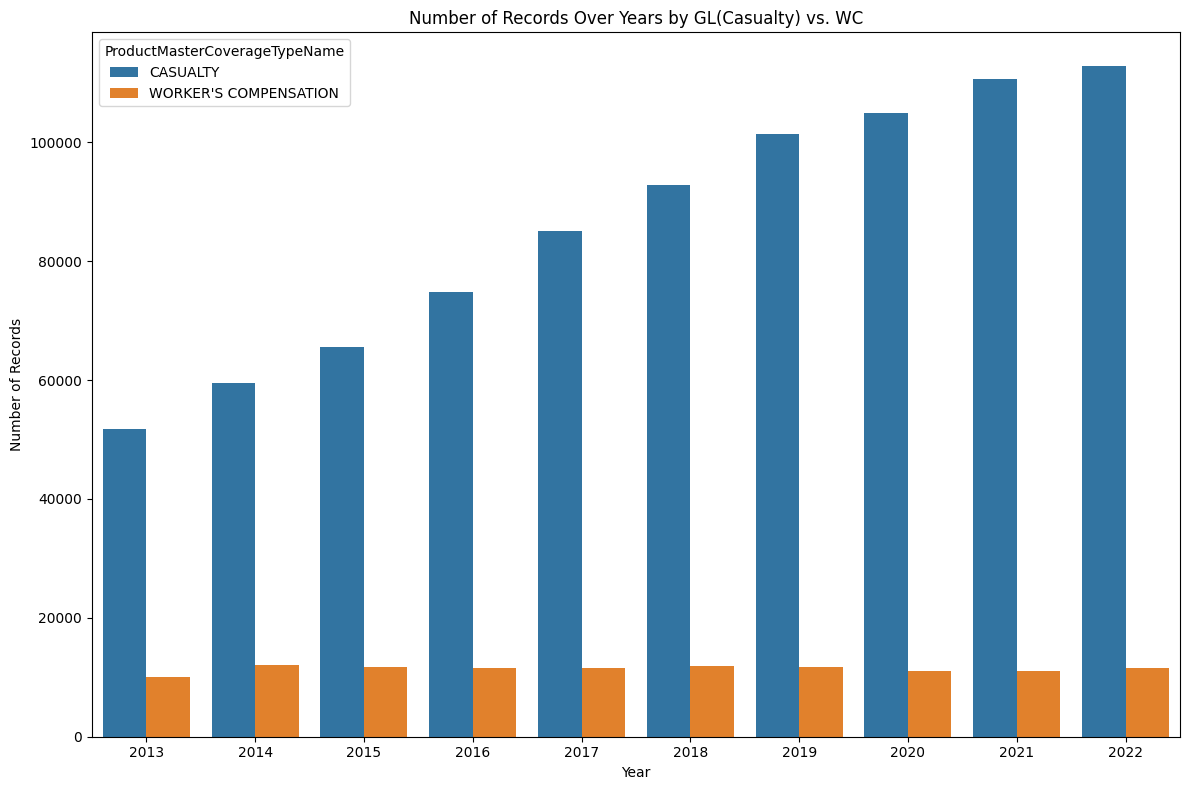

In [202]:
# grouping df by both Year and ProductMasterCoverageTypeName
ProductMasterCoverageTypeName_df_to_plot_2 = df.groupby(['Year', 'ProductMasterCoverageTypeName']).size().reset_index(name='count')

plt.figure(figsize=(12, 8))

#bar plot
sns.barplot(data=ProductMasterCoverageTypeName_df_to_plot_2, x='Year', y='count', hue='ProductMasterCoverageTypeName')

plt.title('Number of Records Over Years by GL(Casualty) vs. WC')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.tight_layout()

plt.show()


##ProductMasterLineName

<ipython-input-204-80e7590ee98b>:16: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



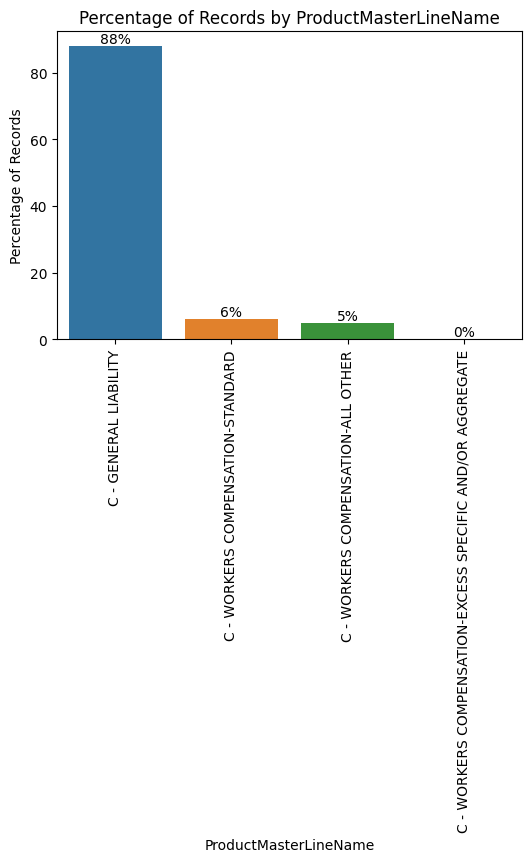

In [204]:
#prepare dataframe to show the distribution of the unique fields within the dimension
ProductMasterLineName_df_to_plot = df.groupby(['ProductMasterLineName']).size().reset_index(name='count')
ProductMasterLineName_df_to_plot['% of Records'] = round(ProductMasterLineName_df_to_plot['count'] / ProductMasterLineName_df_to_plot['count'].sum()*100,0)
plt.figure(figsize=(6, 4))
sorted_df = ProductMasterLineName_df_to_plot.sort_values(by='% of Records', ascending = False)

#barplot
x = sns.barplot(data=sorted_df, x='ProductMasterLineName', y='% of Records', hue='ProductMasterLineName')

for container in x.containers:
    x.bar_label(container, label_type='edge', fontsize=10, fmt='%.0f%%')

plt.title('Percentage of Records by ProductMasterLineName')
plt.ylabel('Percentage of Records')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

## SIC_2_Code

For the sake of readibility, corresponding descriptive field (`IndustryGroupCode`) is not used.

In [215]:
#prepare dataframe to show the distribution of the unique fields within the dimension
SIC_2_Code_df = df[['SIC_2_Code']]
SIC_2_Code_df["SIC_2_Code_to_group"] = df["SIC_2_Code"]
SIC_2_Code_df = SIC_2_Code_df.groupby("SIC_2_Code")
SIC_2_Code_df = SIC_2_Code_df.size().reset_index(name='Count').sort_values(by='Count', ascending=False)
SIC_2_Code_df['% of Rows'] = SIC_2_Code_df['Count'] / SIC_2_Code_df['Count'].sum()

#sunburst chart
fig = px.sunburst(SIC_2_Code_df, path=['SIC_2_Code'], values='% of Rows',color='% of Rows', color_continuous_scale='RdBu_r')

# Adjust layout
fig.update_layout(title='% Distribution of SIC_2_Code Unique Values')
fig.show()

<ipython-input-215-c7cc900800a0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### SIC_2_Code without `UNKNOWN`

<ipython-input-251-7f32d7aa6abe>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



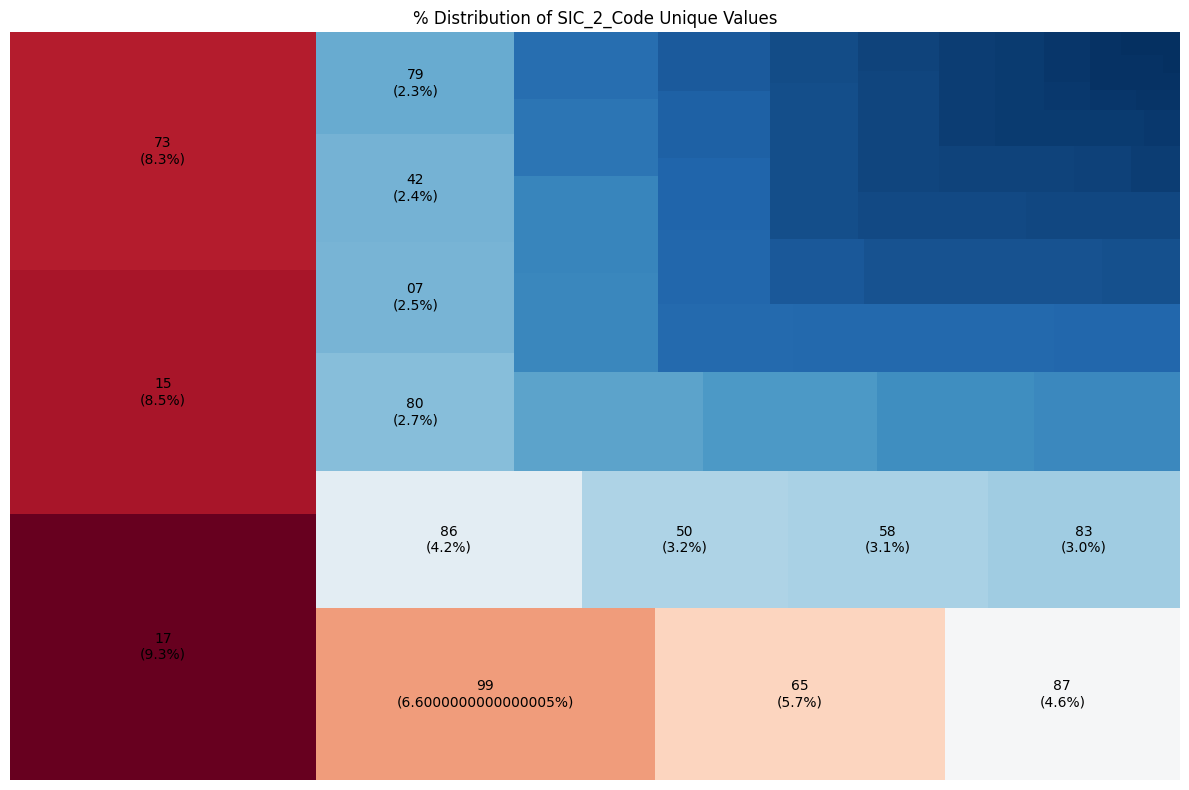

In [251]:
#prepare dataframe to show the distribution of the unique fields within the dimension
SIC_2_Code_df_2 = df[(df['SIC_2_Code']!="UNKNOWN")]
SIC_2_Code_df_2["SIC_2_Code_to_group"] = df["SIC_2_Code"]
SIC_2_Code_df_2 = SIC_2_Code_df_2.groupby("SIC_2_Code")
SIC_2_Code_df_2 = SIC_2_Code_df_2.size().reset_index(name='Count').sort_values(by='Count', ascending=False)
SIC_2_Code_df_2['% of Rows'] = SIC_2_Code_df_2['Count'] / SIC_2_Code_df_2['Count'].sum()

plt.figure(figsize=(12, 8))

#customizing colors
colors = [mcolors.to_hex(c) for c in plt.cm.RdBu_r(SIC_2_Code_df_2['% of Rows'] / SIC_2_Code_df_2['% of Rows'].max())]
SIC_2_Code_df_2 = SIC_2_Code_df_2.sort_values('% of Rows', ascending=False)

#custom label
combo_label = SIC_2_Code_df_2['SIC_2_Code'] + '\n(' + (round(SIC_2_Code_df_2['% of Rows'],3)*100).astype(str) + '%)'
combo_label = np.where(SIC_2_Code_df_2['% of Rows'] < 0.023, '', combo_label)
#treemap
squarify.plot(sizes=SIC_2_Code_df_2['% of Rows'], label=combo_label,color=colors)


plt.axis('off')
plt.title('% Distribution of SIC_2_Code Unique Values')
plt.tight_layout()
plt.show()

##SIC_3_Code

In [247]:
#prepare dataframe to show the distribution of the unique fields within the dimension
SIC_3_Code_df = df[['SIC_3_Code']]
SIC_3_Code_df["SIC_3_Code_to_group"] = df["SIC_3_Code"]
SIC_3_Code_df = SIC_3_Code_df.groupby("SIC_3_Code")
SIC_3_Code_df = SIC_3_Code_df.size().reset_index(name='Count').sort_values(by='Count', ascending=False)
SIC_3_Code_df['% of Rows'] = SIC_3_Code_df['Count'] / SIC_3_Code_df['Count'].sum()

#sunburst chart
fig = px.sunburst(SIC_3_Code_df, path=['SIC_3_Code'], values='% of Rows',color='% of Rows', color_continuous_scale='RdBu_r')

# Adjust layout
fig.update_layout(title='% Distribution of SIC_3_Code Unique Values')
fig.show()

<ipython-input-247-c704a80b452f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### SIC_3_Code without `UNKNOWN`

<ipython-input-250-887f676dcea0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



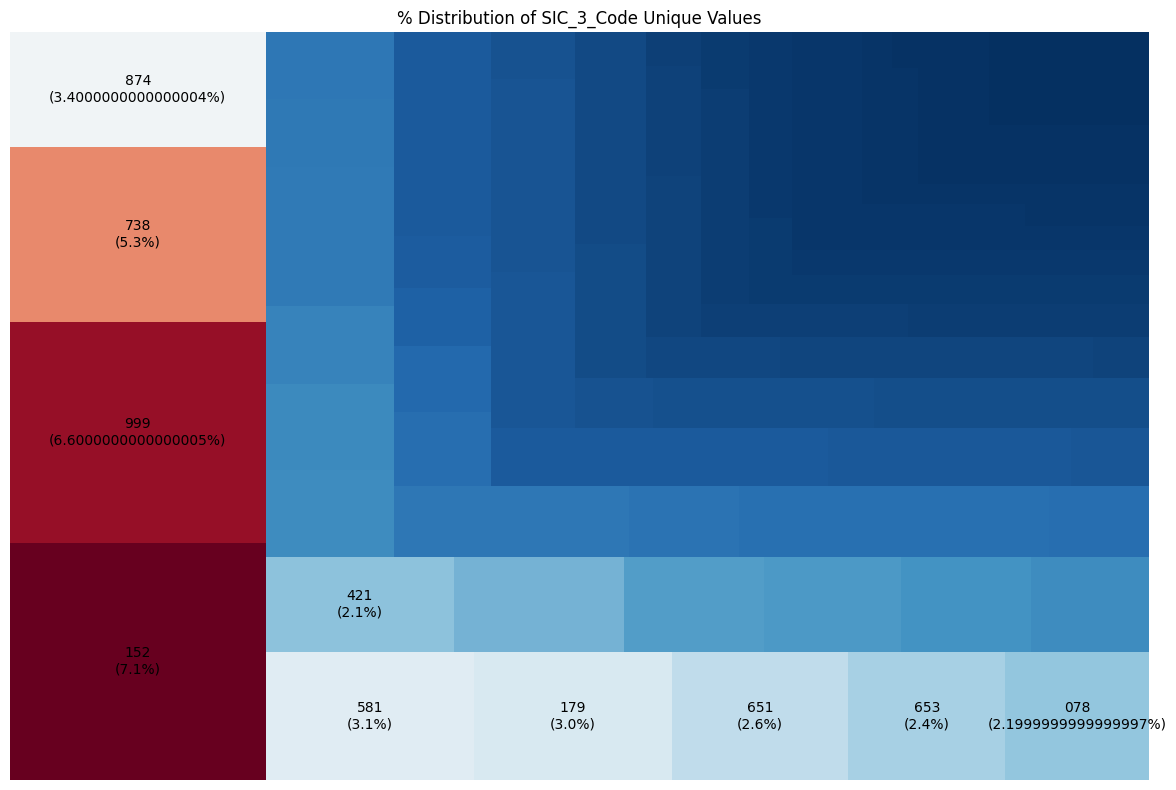

In [250]:
#prepare dataframe to show the distribution of the unique fields within the dimension
SIC_3_Code_df_2 = df[(df['SIC_3_Code']!="UNKNOWN")]
SIC_3_Code_df_2["SIC_3_Code_to_group"] = df["SIC_3_Code"]
SIC_3_Code_df_2 = SIC_3_Code_df_2.groupby("SIC_3_Code")
SIC_3_Code_df_2 = SIC_3_Code_df_2.size().reset_index(name='Count').sort_values(by='Count', ascending=False)
SIC_3_Code_df_2['% of Rows'] = SIC_3_Code_df_2['Count'] / SIC_3_Code_df_2['Count'].sum()

plt.figure(figsize=(12, 8))

#customizing colors
colors = [mcolors.to_hex(c) for c in plt.cm.RdBu_r(SIC_3_Code_df_2['% of Rows'] / SIC_3_Code_df_2['% of Rows'].max())]
SIC_3_Code_df_2 = SIC_3_Code_df_2.sort_values('% of Rows', ascending=False)

#custom label
combo_label = SIC_3_Code_df_2['SIC_3_Code'] + '\n(' + (round(SIC_3_Code_df_2['% of Rows'],3)*100).astype(str) + '%)'
combo_label = np.where(SIC_3_Code_df_2['% of Rows'] < 0.02, '', combo_label)
#treemap
squarify.plot(sizes=SIC_3_Code_df_2['% of Rows'], label=combo_label,color=colors)


plt.axis('off')
plt.title('% Distribution of SIC_3_Code Unique Values')
plt.tight_layout()
plt.show()

##NAICSLevel3Code

No further visuals since, not an interest for analysis.

In [253]:
NAICSLevel3Code_df = df[['NAICSLevel3Code']]
NAICSLevel3Code_df["NAICSLevel3Code_to_group"] = df["NAICSLevel3Code"].copy()
NAICSLevel3Code_df = NAICSLevel3Code_df.groupby("NAICSLevel3Code")
NAICSLevel3Code_df = NAICSLevel3Code_df.size().reset_index(name='Count').sort_values(by='Count', ascending=False)
NAICSLevel3Code_df['% of Rows'] = NAICSLevel3Code_df['Count'] / NAICSLevel3Code_df['Count'].sum()

# create a sunburst chart
fig = px.sunburst(NAICSLevel3Code_df, path=['NAICSLevel3Code'], values='% of Rows',color='% of Rows',color_continuous_scale='RdBu_r')

# adjust layout
fig.update_layout(title='% Distribution of NAICSLevel3Code')

fig.show()

<ipython-input-253-e4c852171d30>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##NAICSLevel4Code

No further visuals since, not an interest for analysis.

In [254]:
NAICSLevel4Code_df = df[['NAICSLevel4Code']]
NAICSLevel4Code_df["NAICSLevel4Code_to_group"] = df["NAICSLevel4Code"].copy()
NAICSLevel4Code_df = NAICSLevel4Code_df.groupby("NAICSLevel4Code")
NAICSLevel4Code_df = NAICSLevel4Code_df.size().reset_index(name='Count').sort_values(by='Count', ascending=False)
NAICSLevel4Code_df['% of Rows'] = NAICSLevel4Code_df['Count'] / NAICSLevel4Code_df['Count'].sum()

# create a sunburst chart
fig = px.sunburst(NAICSLevel4Code_df, path=['NAICSLevel4Code'], values='% of Rows',color='% of Rows',color_continuous_scale='RdBu_r')

# adjust layout
fig.update_layout(title='% Distribution of NAICSLevel4Code')

fig.show()

<ipython-input-254-4b049f80ac9b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## NAICSLevel5Code

No further visuals since, not an interest for analysis.

In [252]:
NAICSLevel5Code_df = df[['NAICSLevel5Code']]
NAICSLevel5Code_df["NAICSLevel5Code_to_group"] = df["NAICSLevel5Code"].copy()
NAICSLevel5Code_df = NAICSLevel5Code_df.groupby("NAICSLevel5Code")
NAICSLevel5Code_df = NAICSLevel5Code_df.size().reset_index(name='Count').sort_values(by='Count', ascending=False)
NAICSLevel5Code_df['% of Rows'] = NAICSLevel5Code_df['Count'] / NAICSLevel5Code_df['Count'].sum()

# create a sunburst chart
fig = px.sunburst(NAICSLevel5Code_df, path=['NAICSLevel5Code'], values='% of Rows',color='% of Rows',color_continuous_scale='RdBu_r')

# adjust layout
fig.update_layout(title='% Distribution of NAICSLevel5Code')

fig.show()

<ipython-input-252-eaba16df6118>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Export Cleaned Data



In [ ]:
all_policy_data_df.shape

(973490, 35)

In [ ]:
gl_policy_data_df= all_policy_data_df[all_policy_data_df["ProductMasterCoverageTypeName"]=="CASUALTY"]

In [ ]:
gl_policy_data_df.shape

(859377, 35)

In [ ]:
wc_policy_data_df= all_policy_data_df[all_policy_data_df["ProductMasterCoverageTypeName"]=="WORKER'S COMPENSATION"]

In [ ]:
wc_policy_data_df.shape

(114113, 35)

In [ ]:
# Save policy_data_df to a csv
gl_policy_data_df.to_csv('./sample_data/GL_Policy_Data_v2.csv', index=False)
wc_policy_data_df.to_csv('./sample_data/WC_Policy_Data_v2.csv', index=False)
all_policy_data_df.to_csv('./sample_data/All_Policy_Data_v2.csv', index=False)

In [ ]:
# Copy the clean_policy_data CSV back to the project shared drive

destination = "/content/drive/Shareddrives/CIS 5450 Group Project/Data/"
!cp -f "$source" "$destination"
#
source = "/content/sample_data/GL_Policy_Data_v2.csv"
!cp -f "$source" "$destination"
#
source = "/content/sample_data/WC_Policy_Data_v2.csv"
!cp -f "$source" "$destination"
#
source = "/content/sample_data/All_Policy_Data_v2.csv"
!cp -f "$source" "$destination"
#!pwd
#!ls -al "$source"
#!ls -al "$destination"
